# Imports

In [1]:
from typing import Literal
import skmisc

import numpy as np
import torch
from torch.distributions import NegativeBinomial, Normal
import os
import sys
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns

# Définir le chemin vers src en remontant depuis le répertoire du notebook
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(src_path)

In [2]:
import scvi
from scvi import REGISTRY_KEYS
from scvi.module.base import BaseModuleClass, LossOutput, auto_move_data
from scvi.external import RNAStereoscope, SpatialStereoscope

p:\Programmes\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tutoriel Data

## Single-cell Data

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 0.0.0-dev


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
adata_path = os.path.join(save_dir.name, "adata.h5ad")

sc_adata = sc.read(
    adata_path,
    backup_url="https://ndownloader.figshare.com/files/26153564",
)
sc_adata

100%|██████████| 124M/124M [00:11<00:00, 11.2MB/s] 


AnnData object with n_obs × n_vars = 35928 × 33538
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

In [6]:
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.obs["combined"] = [
    sc_adata.obs.loc[i, "cell_source"] + sc_adata.obs.loc[i, "donor"] for i in sc_adata.obs_names
]
non_mito_genes_list = [name for name in sc_adata.var_names if not name.startswith("MT-")]
sc_adata = sc_adata[:, non_mito_genes_list]
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum=1e5)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=7000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="combined",
    span=1,
)

C:\Users\paull\AppData\Local\Temp\ipykernel_31932\1378431264.py:7: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  sc_adata.layers["counts"] = sc_adata.X.copy()


## Read in Visium Data

In [7]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Human_Heart")
st_adata.var_names_make_unique()

p:\Programmes\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
p:\Programmes\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
st_adata.var["mt"] = st_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(st_adata, qc_vars=["mt"], inplace=True)
st_adata

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

C:\Users\paull\AppData\Local\Temp\ipykernel_31932\2459342404.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
C:\Users\paull\AppData\Local\Temp\ipykernel_31932\2459342404.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
C:\Users\paull\Ap

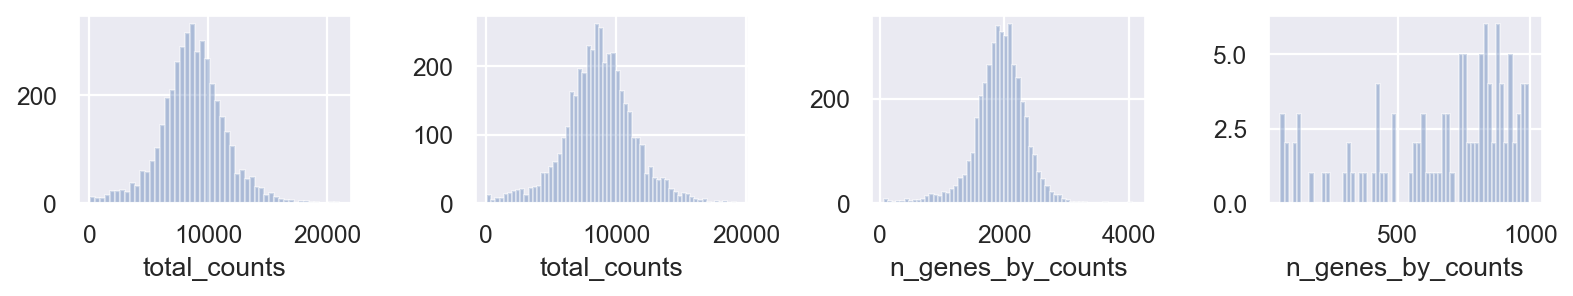

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    st_adata.obs["total_counts"][st_adata.obs["total_counts"] < 20000],
    kde=False,
    bins=60,
    ax=axs[1],
)
sns.distplot(st_adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    st_adata.obs["n_genes_by_counts"][st_adata.obs["n_genes_by_counts"] < 1000],
    kde=False,
    bins=60,
    ax=axs[3],
)
plt.tight_layout()
plt.show()

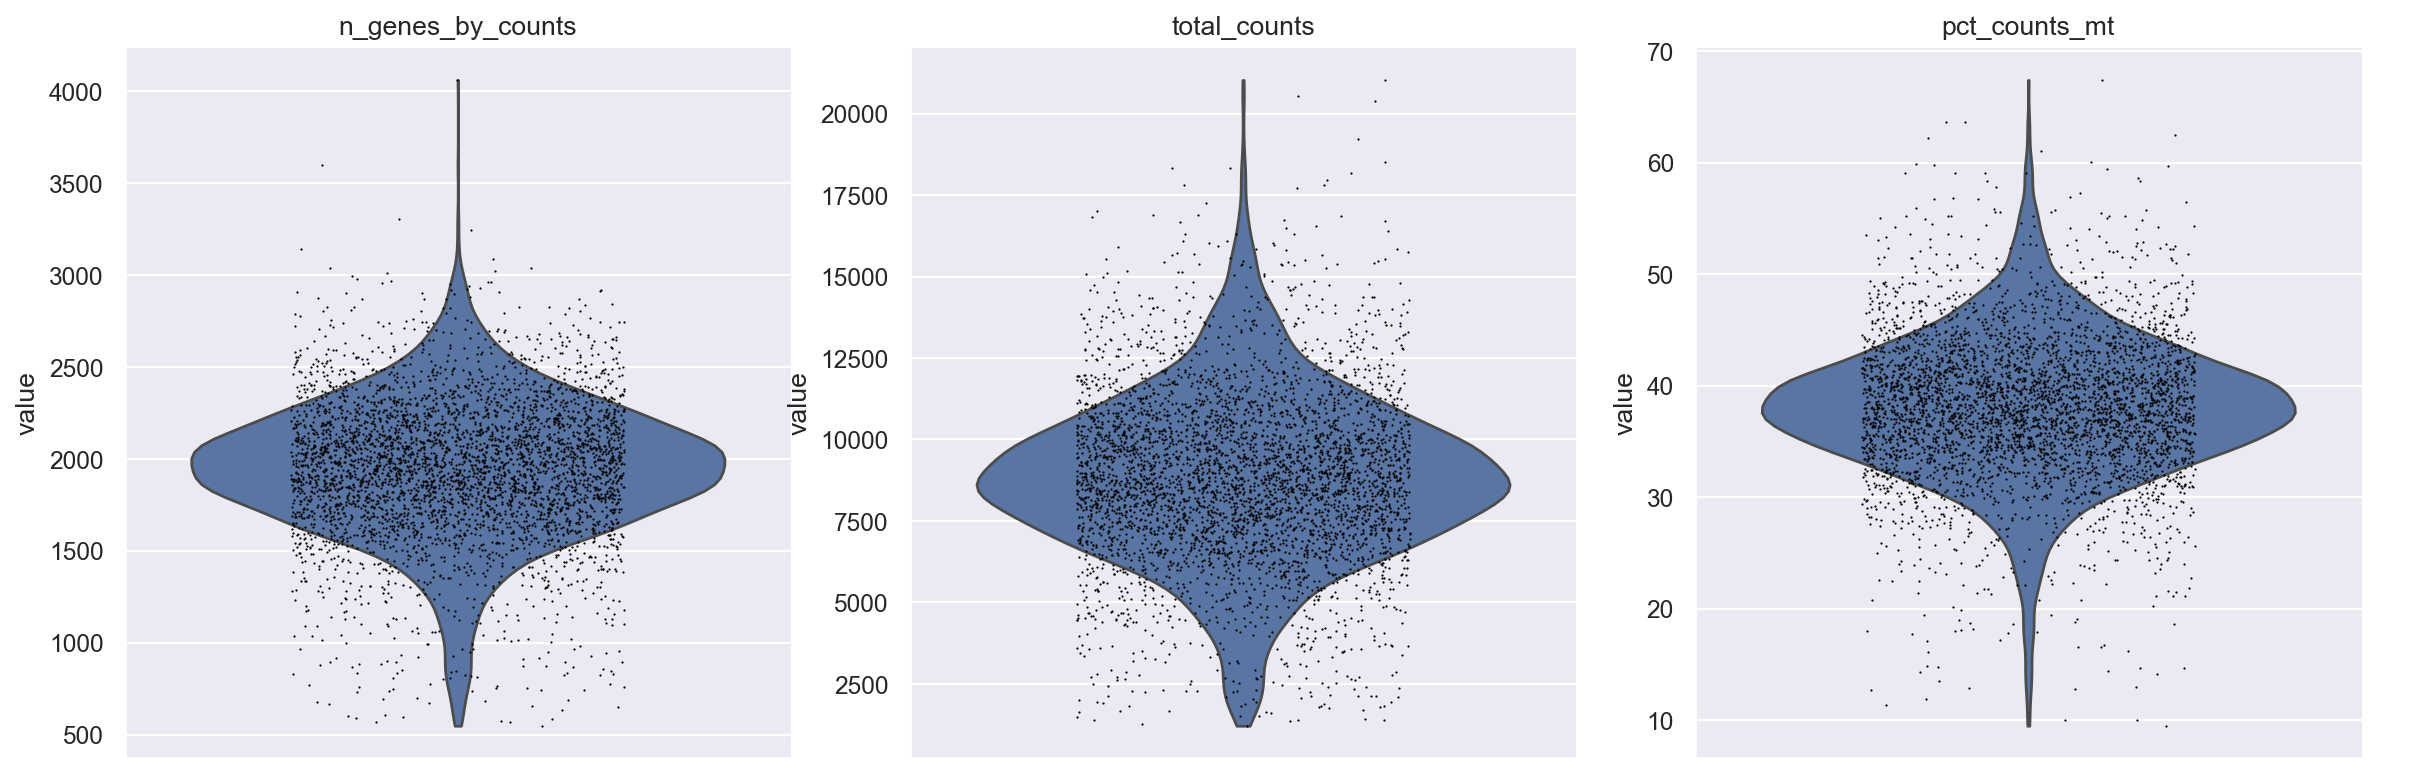

AnnData object with n_obs × n_vars = 4218 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
sc.pp.filter_cells(st_adata, min_counts=500)
sc.pp.filter_cells(st_adata, min_genes=500)
sc.pl.violin(
    st_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.25,
    multi_panel=True,
)
st_adata

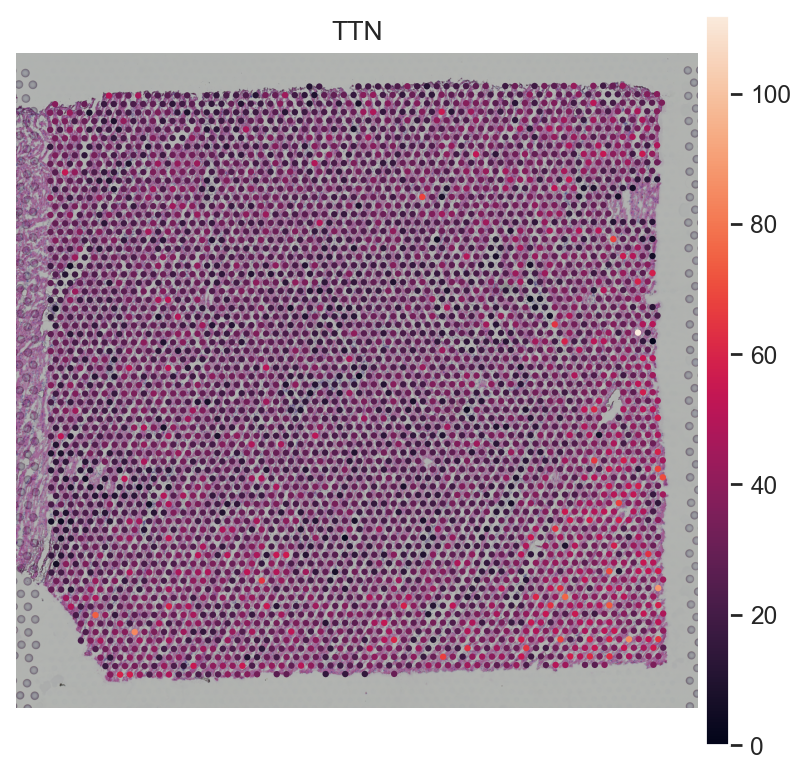

In [11]:
sc.pl.spatial(st_adata, img_key="hires", color=["TTN"])

## First part estimation

In [12]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [13]:
RNAStereoscope.setup_anndata(sc_adata, layer="counts", batch_key = "combined", labels_key="cell_states")
sc_model_path = os.path.join(save_dir.name, "sc_model")
sc_model = RNAStereoscope(sc_adata)

p:\Stage3A\scvi-tools\src\scvi\data\fields\_dataframe_field.py:186: UserWarning: Category 39 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [14]:
sc_adata.obs["_scvi_labels"].unique().shape

(53,)

In [14]:
sc_model.train(max_epochs=100)
sc_model.history["elbo_train"][10:].plot()
sc_model.save(sc_model_path, overwrite=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
p:\Programmes\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 3/100:   2%|▏         | 2/100 [00:56<46:11, 28.28s/it, v_num=1, train_loss_step=3.11e+7, train_loss_epoch=7.21e+7]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Proportion estimation

In [15]:
st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

In [16]:
spatial_model_path = os.path.join(save_dir.name, "spatial_model")

spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
spatial_model.train(max_epochs=2000)
spatial_model.history["elbo_train"][10:].plot()
spatial_model.save(spatial_model_path, overwrite=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
p:\Programmes\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 12/2000:   1%|          | 11/2000 [00:27<1:23:13,  2.51s/it, v_num=1, train_loss_step=8.14e+10, train_loss_epoch=8.53e+10]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

In [ ]:
# low dpi for uploading to github
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sc.pl.spatial(
    st_adata,
    img_key="hires",
    color=["EC5_art", "EC6_ven"],
    size=1.2,
    color_map="inferno",
)